# Liver Cirrhosis Stage Prediction - Modelling

In this notebook we'll create our model.

# 📚 1. Import Libraries

In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.float_format', lambda x:'%.3f' % x)
import warnings
warnings.simplefilter(action="ignore", category=Warning)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sb
# Configure default settings for plots
sb.set(style='ticks')
sb.set_palette('Paired')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
# Data Processing Librariies
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## Algorithms
# Ensemble Methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Non-linear Methods
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Performance Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

# Save model
import pickle

# 📖 2. Load Data

In [2]:
raw_data = pd.read_csv('./Data/Processed/df_no_duplicates.csv')
raw_data.shape

(9639, 19)

In [11]:
# Creating a copy of the dataframe in case we need the raw data in the next sections
df = raw_data.copy()

# 🧹 3. Data Preparation

We previously dropped all the duplicated records. Since there is no null values in the dataset, we'll apply outlier removal only. Then, moev to the data tranformation section.

In [12]:
# Since it's a classification problem, we'll convert the target into object datatype
df['Stage'] = df['Stage'].astype('object')

In [13]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)
        
# Removing the label from the categorical column list
cat_features = cat_cols[:-1]
target = 'Stage'

print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

Categorical columns: 8 ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
Numeric columns: 11 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']


## 3.1. Handling Outliers

- Age <= 27500
- Bilirubin <= 10
- Cholesterol <= 600
- 2.5 <= Albumin <= 4.5
- Copper <= 200
- Alk_Phos <= 4000
- SGOT <= 200
- Tryglicerides <= 200
- Platelets <= 500
- Prothrombin <= 13

In [14]:
df_no_outliers = df[(df['Age'] <= 27500) & 
                   (df['Bilirubin'] <= 6) & 
                   (df['Cholesterol'] <= 600) &
                   (df['Albumin'] >= 2.5) & (df['Albumin'] <= 4.5) &
                   (df['Copper'] <= 200) &  
                   (df['Alk_Phos'] < 4000) &
                   (df['SGOT'] <= 200) &
                   (df['Tryglicerides'] <= 200) &
                   (df['Platelets'] <= 500) &
                   (df['Prothrombin'] <= 13)]
df_no_outliers.reset_index(inplace=True, drop=True)
df_no_outliers.to_csv('./Data/Processed/df_no_outliers.csv', index=False)
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6289 entries, 0 to 6288
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         6289 non-null   int64  
 1   Status         6289 non-null   object 
 2   Drug           6289 non-null   object 
 3   Age            6289 non-null   int64  
 4   Sex            6289 non-null   object 
 5   Ascites        6289 non-null   object 
 6   Hepatomegaly   6289 non-null   object 
 7   Spiders        6289 non-null   object 
 8   Edema          6289 non-null   object 
 9   Bilirubin      6289 non-null   float64
 10  Cholesterol    6289 non-null   float64
 11  Albumin        6289 non-null   float64
 12  Copper         6289 non-null   float64
 13  Alk_Phos       6289 non-null   float64
 14  SGOT           6289 non-null   float64
 15  Tryglicerides  6289 non-null   float64
 16  Platelets      6289 non-null   float64
 17  Prothrombin    6289 non-null   float64
 18  Stage   

In [15]:
df_no_outliers['Stage'].value_counts()

1    2226
2    2178
3    1885
Name: Stage, dtype: int64

🔎 **Observations:** After removing the outliers the balance of the dataset is not impacted.

In [6]:
def dist_plot(data, feature_list):
    # number of columns of the subplots
    n_cols = 2 
    # set the number of rows with the predefined number of columns
    n_rows = int(np.ceil(len(feature_list)/n_cols)) 

    # Create figure
    fig = plt.figure(figsize=(16, 4*n_rows))
    outer = gridspec.GridSpec(n_rows, n_cols, wspace=0.2, hspace=0.3)

    for i in range(len(feature_list)):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], 
                                                 wspace=0.1, hspace=0.1, height_ratios=(0.15, 0.85))

        ax_box = plt.Subplot(fig, inner[0])
        sb.boxplot(data=data, x=feature_list[i], color='lightblue', ax=ax_box)
        ax_box.set_xlabel('')
        fig.add_subplot(ax_box)

        mean_value = data[feature_list[i]].mean()
        median_value = data[feature_list[i]].median()
        ax_hist = plt.Subplot(fig, inner[1])
        sb.histplot(data=data, x=feature_list[i], kde=True, ax=ax_hist)
        ax_hist.axvline(mean_value, color='green', linestyle='dotted', linewidth=2, label='Mean')
        ax_hist.axvline(median_value, color='purple', linestyle='dotted', linewidth=2, label='Median')
        # Add a legend
        ax_hist.legend(loc='lower right', fontsize=10)

        # Calculate skewness and kurtosis
        skewness = data[feature_list[i]].skew()
        kurt = data[feature_list[i]].kurt()
        if skewness < 0:
            x=0.25
        else:
            x=0.95
        # Add skewness and kurtosis as text on the histogram plot
        ax_hist.text(x, 0.85, f"Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}", 
                         transform=ax_hist.transAxes, verticalalignment='top', horizontalalignment='right',
                         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'),
                    fontsize=10)
        fig.add_subplot(ax_hist)

    plt.tight_layout()
    plt.show(block=False)

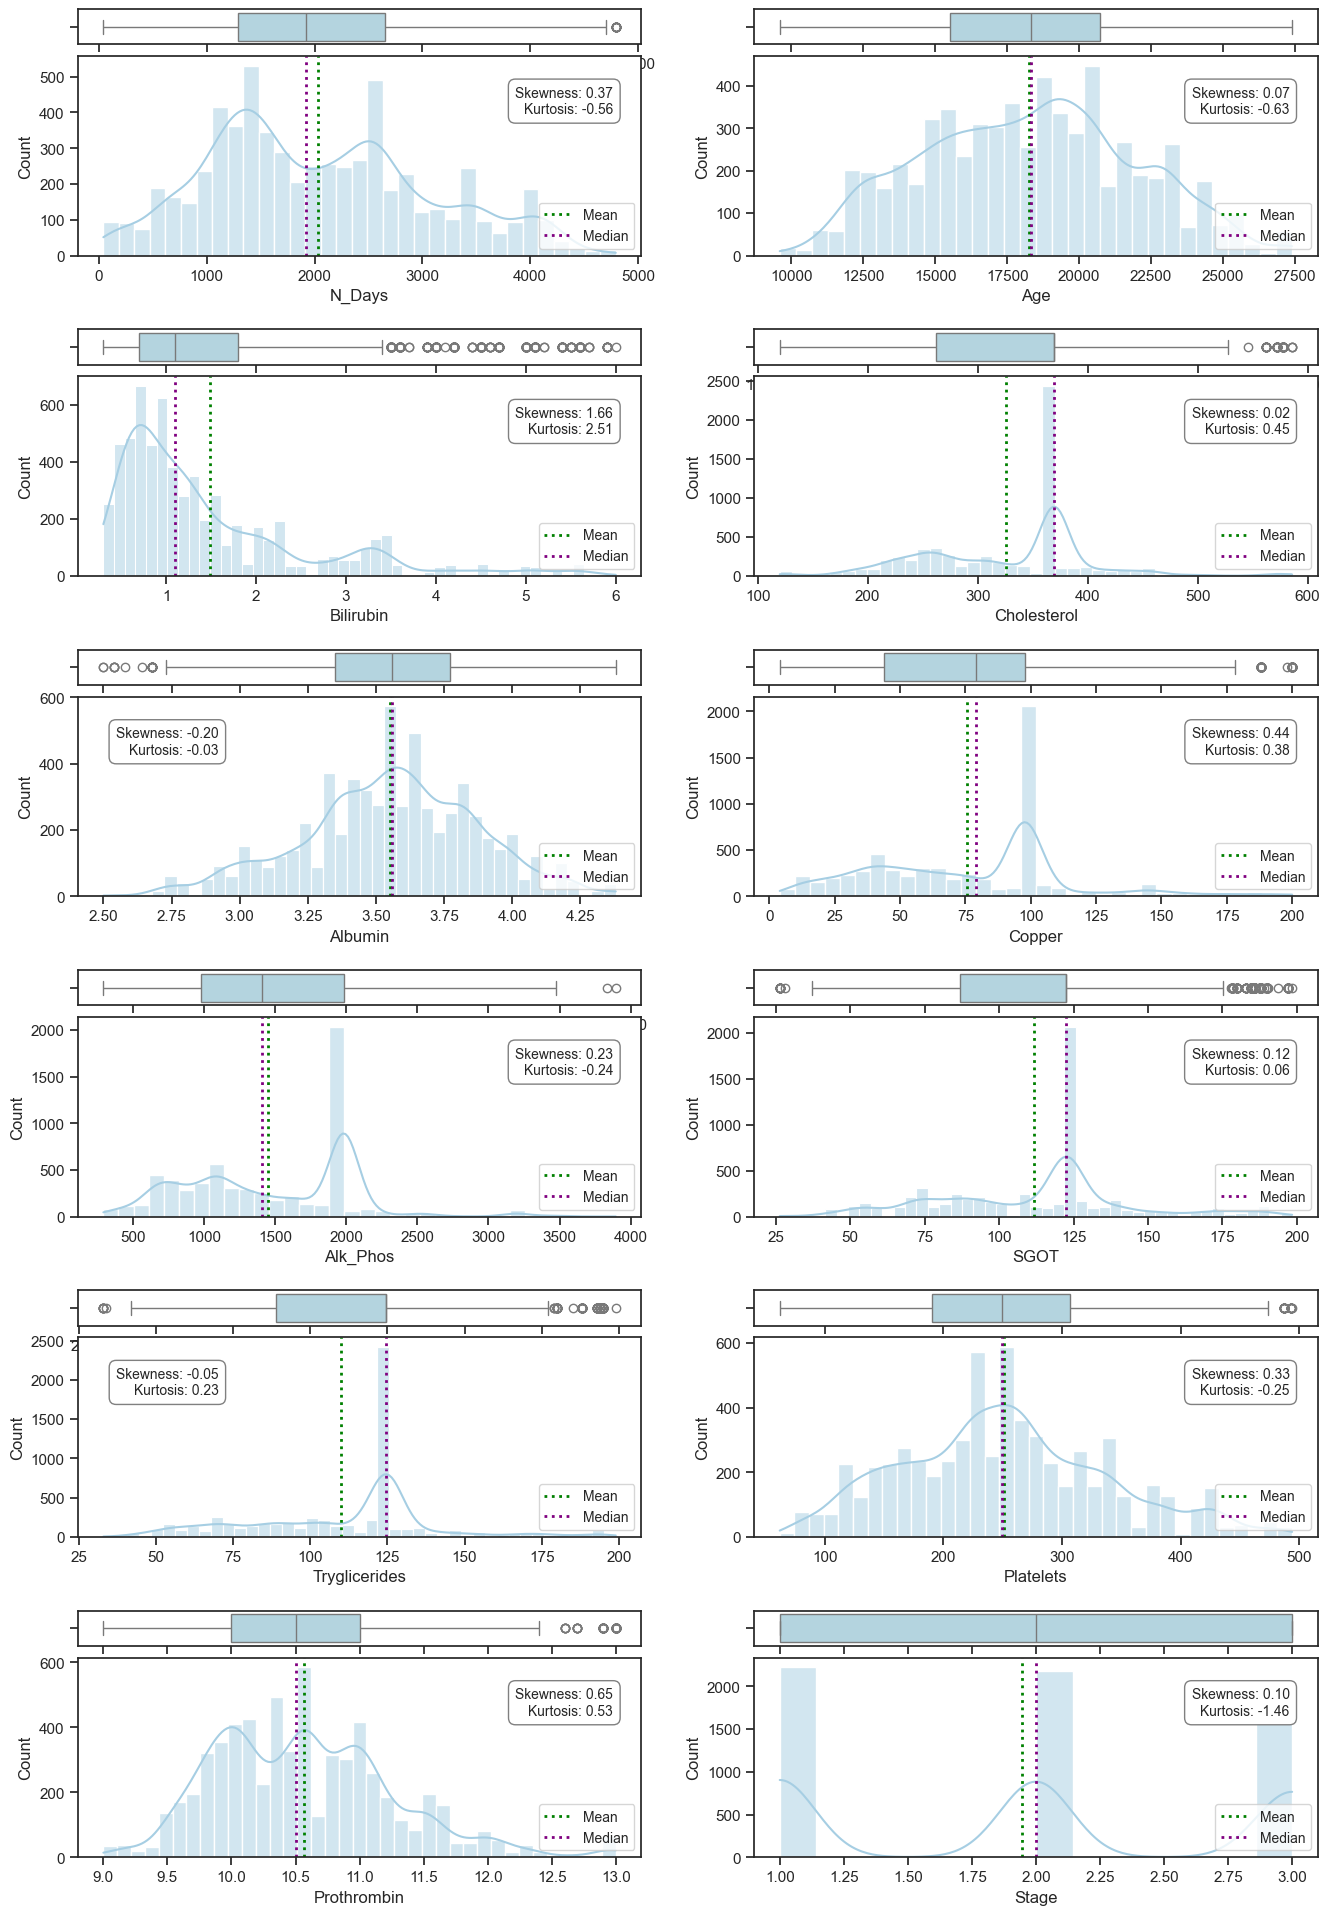

In [8]:
dist_plot(df_no_outliers, num_cols)

## 3.2. Transform Dataset

In [53]:
def transform_data(df, target, num_features, cat_features):
    # Encoding target
    lbl_encoder = LabelEncoder()
    df_no_outliers[target+'_Encoded'] = lbl_encoder.fit_transform(df_no_outliers[target])
    df_no_outliers[target+'_Encoded'].value_counts()
    
    # Assign features and labels
    x = df_no_outliers.drop([target, target+'_Encoded'], axis=1)
    y = df_no_outliers[target+'_Encoded']
    
    # Split the dataset into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
    
    # Standardization and Encoding
    # Define transformers for different column types
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

    # Combine transformers for specific columns
    preprocessor = ColumnTransformer([
        ("num", numerical_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ])

    # Fit transformers on training data only
    preprocessor.fit(x_train)

    # Transform train and test data using fitted transformers
    x_train_transformed = preprocessor.transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)
    
    # Save the preprocessor
    with open('../Models/data_preprocessor.pkl', 'wb') as preprocessor_file:
        pickle.dump(preprocessor, preprocessor_file)
    
    return x_train_transformed, x_test_transformed, y_train, y_test

In [16]:
x_train, x_test, y_train, y_test = transform_data(df_no_outliers, target, num_cols, cat_features)

# 🧱 4. Model Building

## 4.1. Comparing Different Algorithms

In this section we'll compare non-linear and ensemble algorithms using k-fold cross validation and then decide on the candidate algorith for hyperparameter tunin based on the accuracy metric.

In [17]:
def model_evaluation(x, y, models):
    '''
        This function takes x, y and models and applies 
        k-fold cross validation to the each algorithm in 
        the models list by using x and y training set. 
        Displays the mean and standard deviation of 
        accuracy, precision, recall, f1 scores in tabular
        format and boxplots.

        ---
        ### Parameters
        - x <array>: Feature values.
        - y <array>: Target values.
        - models <list>: List of the model objects to be vealuated.
    '''
    
    names = []
    scoring = ['accuracy']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Mean', 'Acc STD'])
    results_acc = [] # List of accuracy scores for each fold of each algorithm
    
    for name, model in models:
        names.append(name)
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)
        result = cross_validate(model, x, y, cv=kfold, scoring=scoring)
    
        # Mean and standard deviation of Accuracy scores for the algorithm
        acc_mean = result['test_accuracy'].mean()
        acc_std = result['test_accuracy'].std()
        
        # Create the row of the results
        df_result_row = {'Algorithm': name, 'Acc Mean': acc_mean, 'Acc STD': acc_std}
        # Add the row to the results data frame
        df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
        
        results_acc.append(result['test_accuracy'])
        
    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # Display the mean and standard deviation of all metrics for all algorithms
    print(df_results)
    
    # Display the overall results in a boxplot graph
    width = (len(models)*2)
    plot_objects = plt.subplots(nrows=1, ncols=1, figsize=(width, 6))
    fig, ax = plot_objects
    
    ax.boxplot(results_acc)
    ax.set_title('Accuracy', fontsize=14)
    ax.set_xticklabels(names, rotation=30)
    plt.tight_layout()
    plt.show()

### 4.1.1. Ensemble Mehtods

In [18]:
ens_models = []
ens_models.append(('RFC', RandomForestClassifier()))
ens_models.append(('ABC', AdaBoostClassifier()))
ens_models.append(('GBC', GradientBoostingClassifier()))

           Acc Mean  Acc STD
Algorithm                   
RFC           0.848    0.014
ABC           0.620    0.018
GBC           0.786    0.019


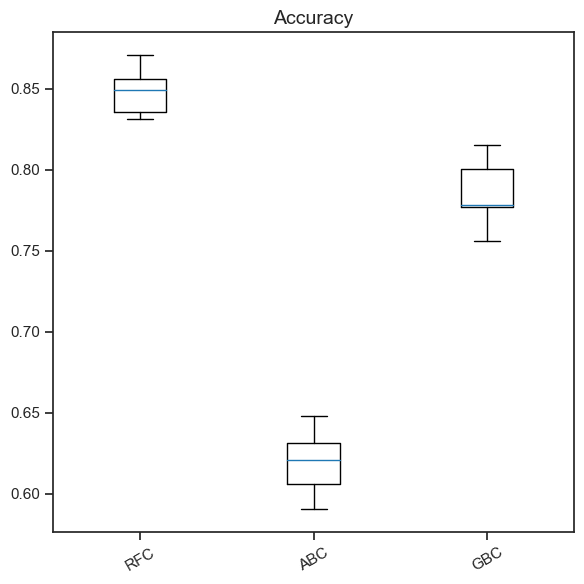

In [19]:
model_evaluation(x_train, y_train, ens_models)

🔎 **Observations:** RandomForestClassifier outperformes the rest ensemble methods. This migh be a good candidate for the final model.

### 4.1.2. Non-linear Methods

In [20]:
nl_models = []
nl_models.append(('SVC', SVC()))
nl_models.append(('DTC', DecisionTreeClassifier()))
nl_models.append(('KNN', KNeighborsClassifier()))
nl_models.append(('GNB', GaussianNB()))
nl_models.append(('XGB', XGBClassifier()))

           Acc Mean  Acc STD
Algorithm                   
SVC           0.690    0.013
DTC           0.743    0.018
KNN           0.717    0.013
GNB           0.516    0.018
XGB           0.882    0.012


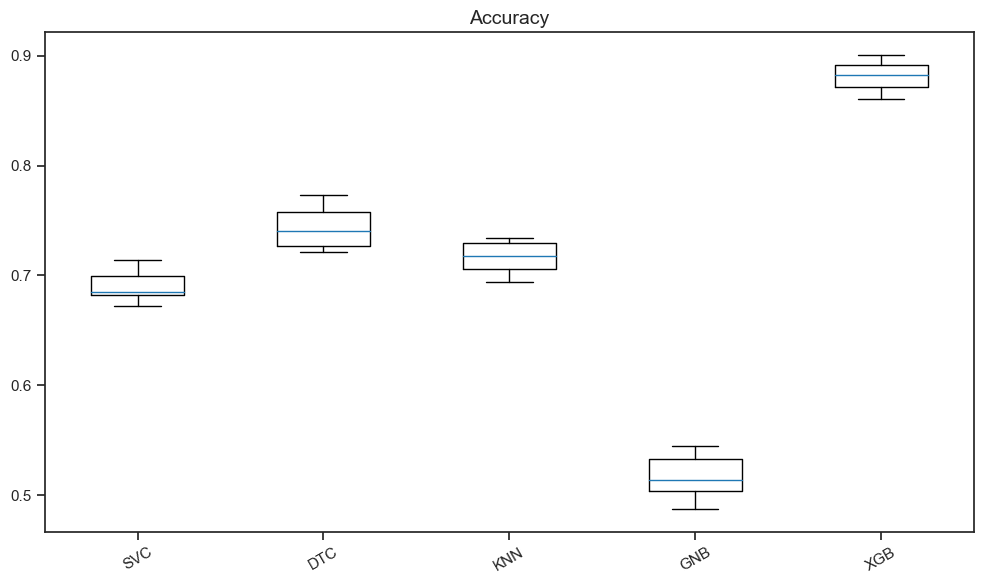

In [21]:
model_evaluation(x_train, y_train, nl_models)

🔎 **Observations:** XBG provides the best accuracy score among the others. We'll continue with the hyperparameter tuning of XGB.

# 🏁 5. Finalizing Model

## 5.1. Hyperparameter Tuning

In [22]:
model_xgb = XGBClassifier()

crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

h_params = {
    'learning_rate': [0.05, 0.1, 0.3],  # Common learning rates for XGBoost
    'max_depth': [3, 5, 8],  # Experiment with different tree depths
    'n_estimators': [100, 300, 500],  # Experiment with number of trees
    'subsample': [0.5, 0.7, 1]  # Experiment with subsampling ratio
}
grid = GridSearchCV(
    estimator = model_xgb,
    param_grid = h_params,
    scoring = 'accuracy', 
    n_jobs = -1,
    cv = crossvalidation
)

grid.fit(x_train, y_train)

# Print the best score and the hyper parameters that provides that score
grid.best_params_, grid.best_score_

({'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 1},
 0.8865036197906898)

In [23]:
model = XGBClassifier(**grid.best_params_)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [24]:
y_hat = model.predict(x_test)

In [25]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       445
           1       0.88      0.88      0.88       436
           2       0.92      0.92      0.92       377

    accuracy                           0.89      1258
   macro avg       0.89      0.89      0.89      1258
weighted avg       0.89      0.89      0.89      1258



In [26]:
def plot_confusion_matrix(y_test, predictions):
    # Plot the confusion matrix
    cf_matrix = confusion_matrix(y_test, predictions)
    fig = plt.subplots(figsize=(10, 8))
    sb.set(font_scale=1.4)
    sb.heatmap(cf_matrix, annot=True,  fmt='d')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    # Reset font scale to default
    sb.set(font_scale=1)

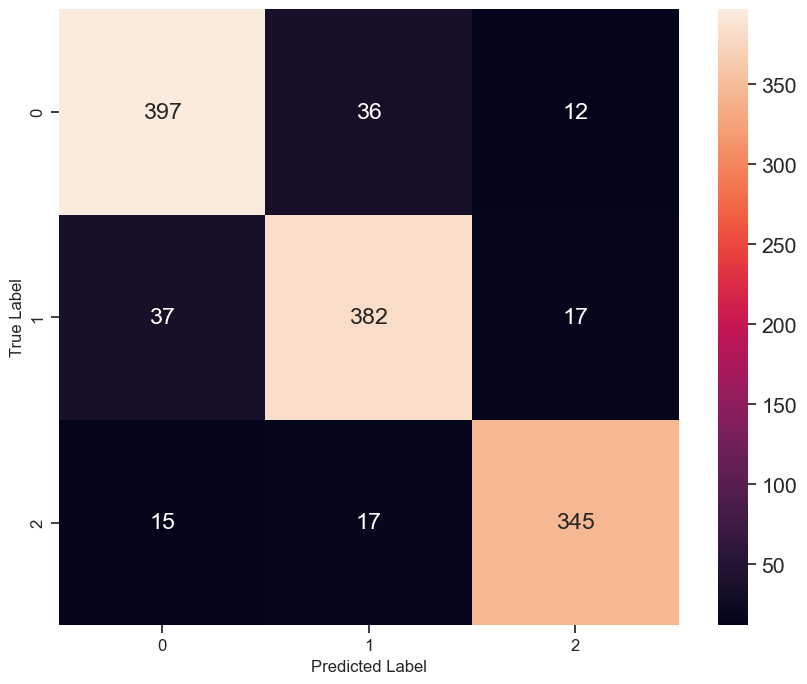

In [27]:
plot_confusion_matrix(y_test, y_hat)

In [28]:
def plot_roc_curve(y_true, predictions, estimator=None, class_names=None):
  """
  Plots ROC curves for all classes in a multi-class classification problem.

  Args:
    y_true: True labels for each data point.
    predictions: Predicted scores for each data point (should be probabilities).
    class_names: Names of the classes (optional).
    estimator: The name of the estimator.

  Returns:
    None. The ROC curve is plotted directly.
  """

  # Ensure binary representation of classes
  n_classes = len(np.unique(y_true))
  if n_classes < 2:
    raise ValueError("y_true must contain at least two classes.")
  
  predictions = predictions.flatten()

  # Initialize figure and subplot
  plt.figure(figsize=(14, 8))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot perfect classification line

  # Calculate ROC curves for each class
  fpr, tpr, roc_auc = {}, {}, {}
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])
    label = ''
    if class_names:
      label = '%s (AUC = %0.2f)' % (class_names[i], roc_auc[i])
    else:
      label = 'Class %d (AUC = %0.2f)' % (i, roc_auc[i])
    plt.plot(fpr[i], tpr[i], label=label)

  # Customize plot
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for Multi-class Classification: {estimator}')
  plt.legend(loc="lower right")

  plt.show()  

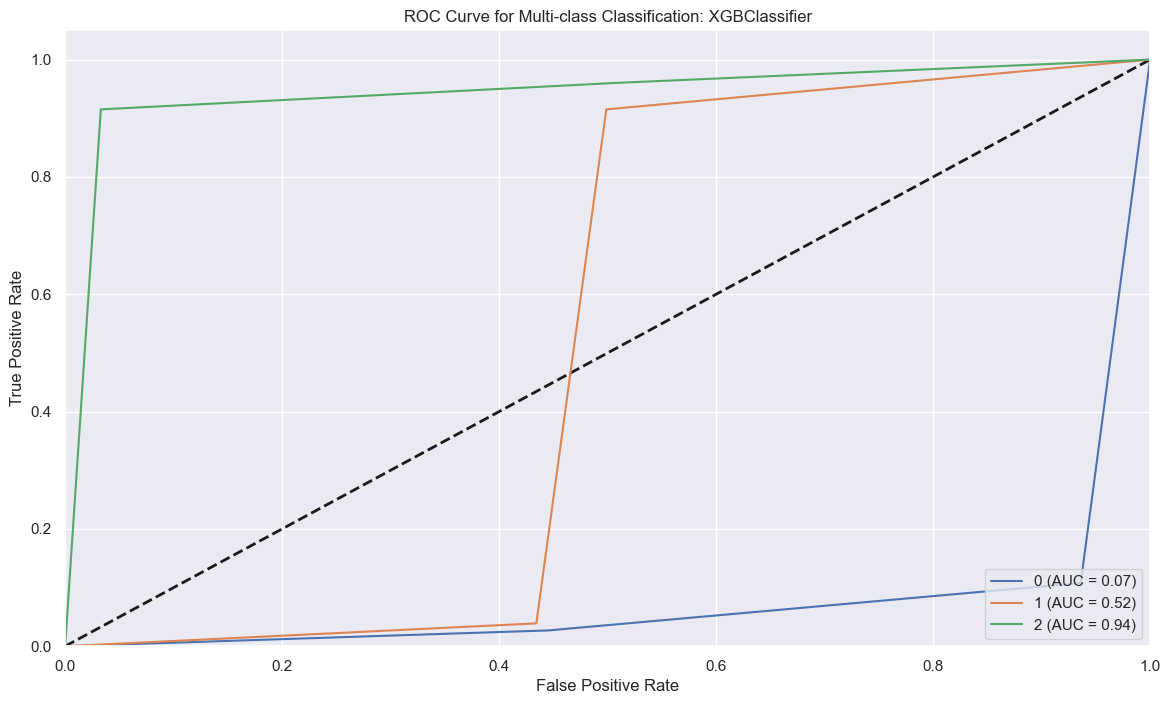

In [29]:
plot_roc_curve(y_test, y_hat, 'XGBClassifier', class_names=[0, 1, 2])

🔎 **Observations:** We have a very low AUC value which might be an indicator with the model. Before deep diving into the root cause, We'd like to perform a test with the default hyperparameters of XGB to see if there is any improvement.

## 5.2. Training with Default Hyperparameters

In [30]:
model_def = XGBClassifier()
model_def.fit(x_train, y_train)
y_hat = model_def.predict(x_test)

In [31]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       445
           1       0.87      0.89      0.88       436
           2       0.92      0.93      0.92       377

    accuracy                           0.90      1258
   macro avg       0.90      0.90      0.90      1258
weighted avg       0.90      0.90      0.90      1258



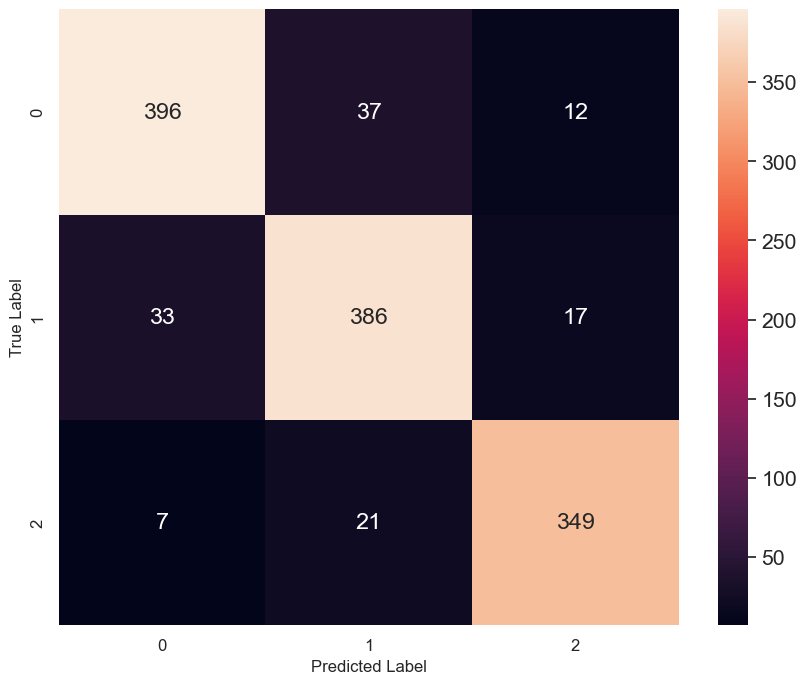

In [32]:
plot_confusion_matrix(y_test, y_hat)

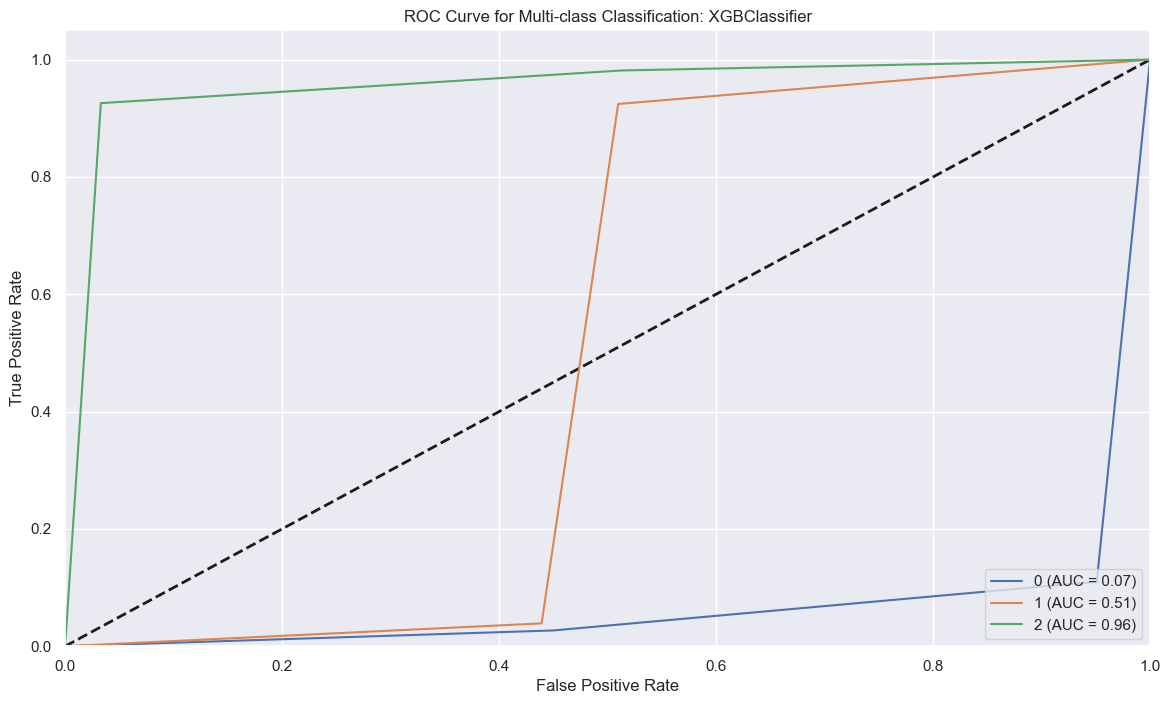

In [33]:
plot_roc_curve(y_test, y_hat, 'XGBClassifier', class_names=[0, 1, 2])

🔎 **Observations:**

> The Area Under the ROC Curve (AUC) summarizes the performance of a binary classification model across all possible classification thresholds. In multi-class classification, the AUC represents the ability of a model to discriminate between different classes across all possible classification thresholds.

Since our dataset is balanced and we have high precision and recall scores for each class, yet we observe discrepancies between F1-score and AUC, let's check Class Separability using Principal Component Analysis (PCA)

## 5.3. Checking the Class Separability

### 5.3.1. Visualizing the training set with 3 principal component

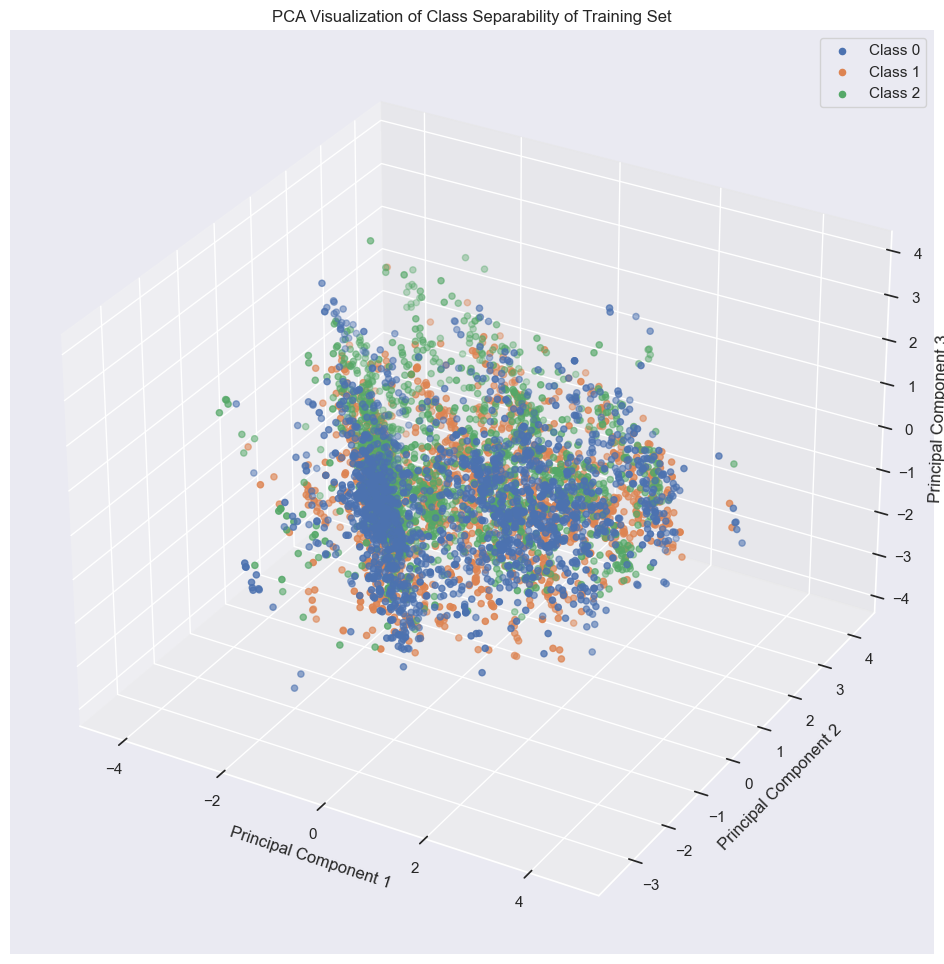

In [34]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_train)

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for target_class in np.unique(y_train):
     ax.scatter(x_pca[y_train == target_class, 0], x_pca[y_train == target_class, 1], x_pca[y_train == target_class, 2], label=f'Class {target_class}')

ax.set_title('PCA Visualization of Class Separability of Training Set')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

### 5.3.1. Visualizing the test set with 3 principal component

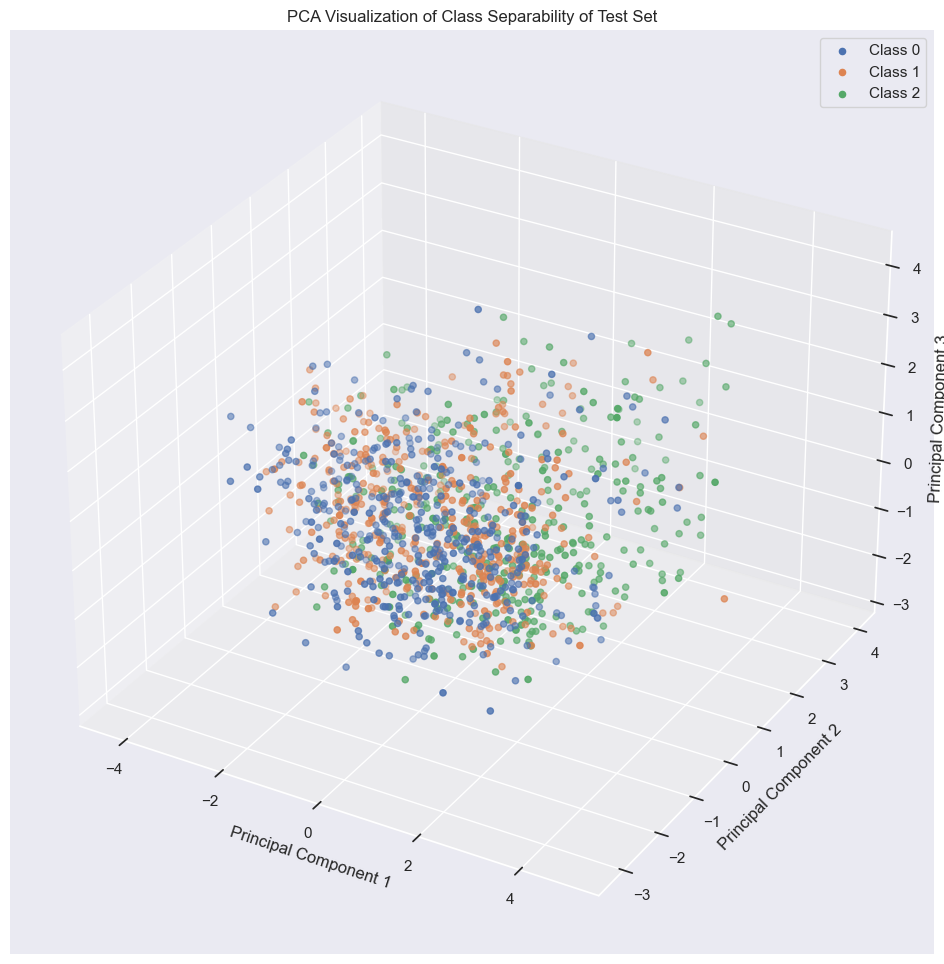

In [35]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_test)

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for target_class in np.unique(y_test):
     ax.scatter(x_pca[y_test == target_class, 0], x_pca[y_test == target_class, 1], x_pca[y_test == target_class, 2], label=f'Class {target_class}')

ax.set_title('PCA Visualization of Class Separability of Test Set')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

🔎 **Observations:** Especially for the test set, the class separability is low. Let's check the distribution of the categorical features in the dataset and remove the ones with low frequency to simplify the model.

In [36]:
# Function to create labeled barplots for categorical features
def plot_counts(data, features, hue=None):
    
    """
    This function takes the name of the feature and plots the distribution
    of the categorical values and saves the figure for future usage using
    countplot function of seaborn.

    ---
    ### Parameters:
    - data <dataframe>: tabular data in data frame format.
    - features <list>: List of categorical columns in dataframe to be visualized.
    - hue <string>: Name of the hue.
    """
    
    # number of columns of the subplots
    n_cols = 2 
    # set the number of rows with the predefined number of columns
    n_rows = int(np.ceil(len(features)/n_cols)) 

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, feature in enumerate(features):
        #bar_container = axes[i].bar(df[feature].value_counts().index, df[feature].value_counts().values)
        sb.countplot(
            data = data,
            x = feature,
            palette = 'Paired',
            hue = hue,
            ax = axes[i]
        )
        # Display count of each level of the category
        for p in axes[i].patches:
            label = p.get_height()
            x = p.get_x() + p.get_width() / 2 # Width of the plot
            y = p.get_height() # Height of the plot
            
            rotation = 0
            if hue is not None:
                rotation = 30  # Rotate annotations by 30 degrees if hue is not None

            axes[i].annotate(
                '{:.0f}'.format(label),
                (x, y),
                ha = 'center',
                va = 'center',
                size = 12,
                xytext = (0, 5),
                textcoords = 'offset points',
                rotation = rotation
            )
            
        axes[i].set(ylabel='Count', title=feature, xlabel='')
        axes[i].tick_params(axis='x', rotation=0)

    # If the number of features is odd, remove the empty subplot
    if len(features) % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

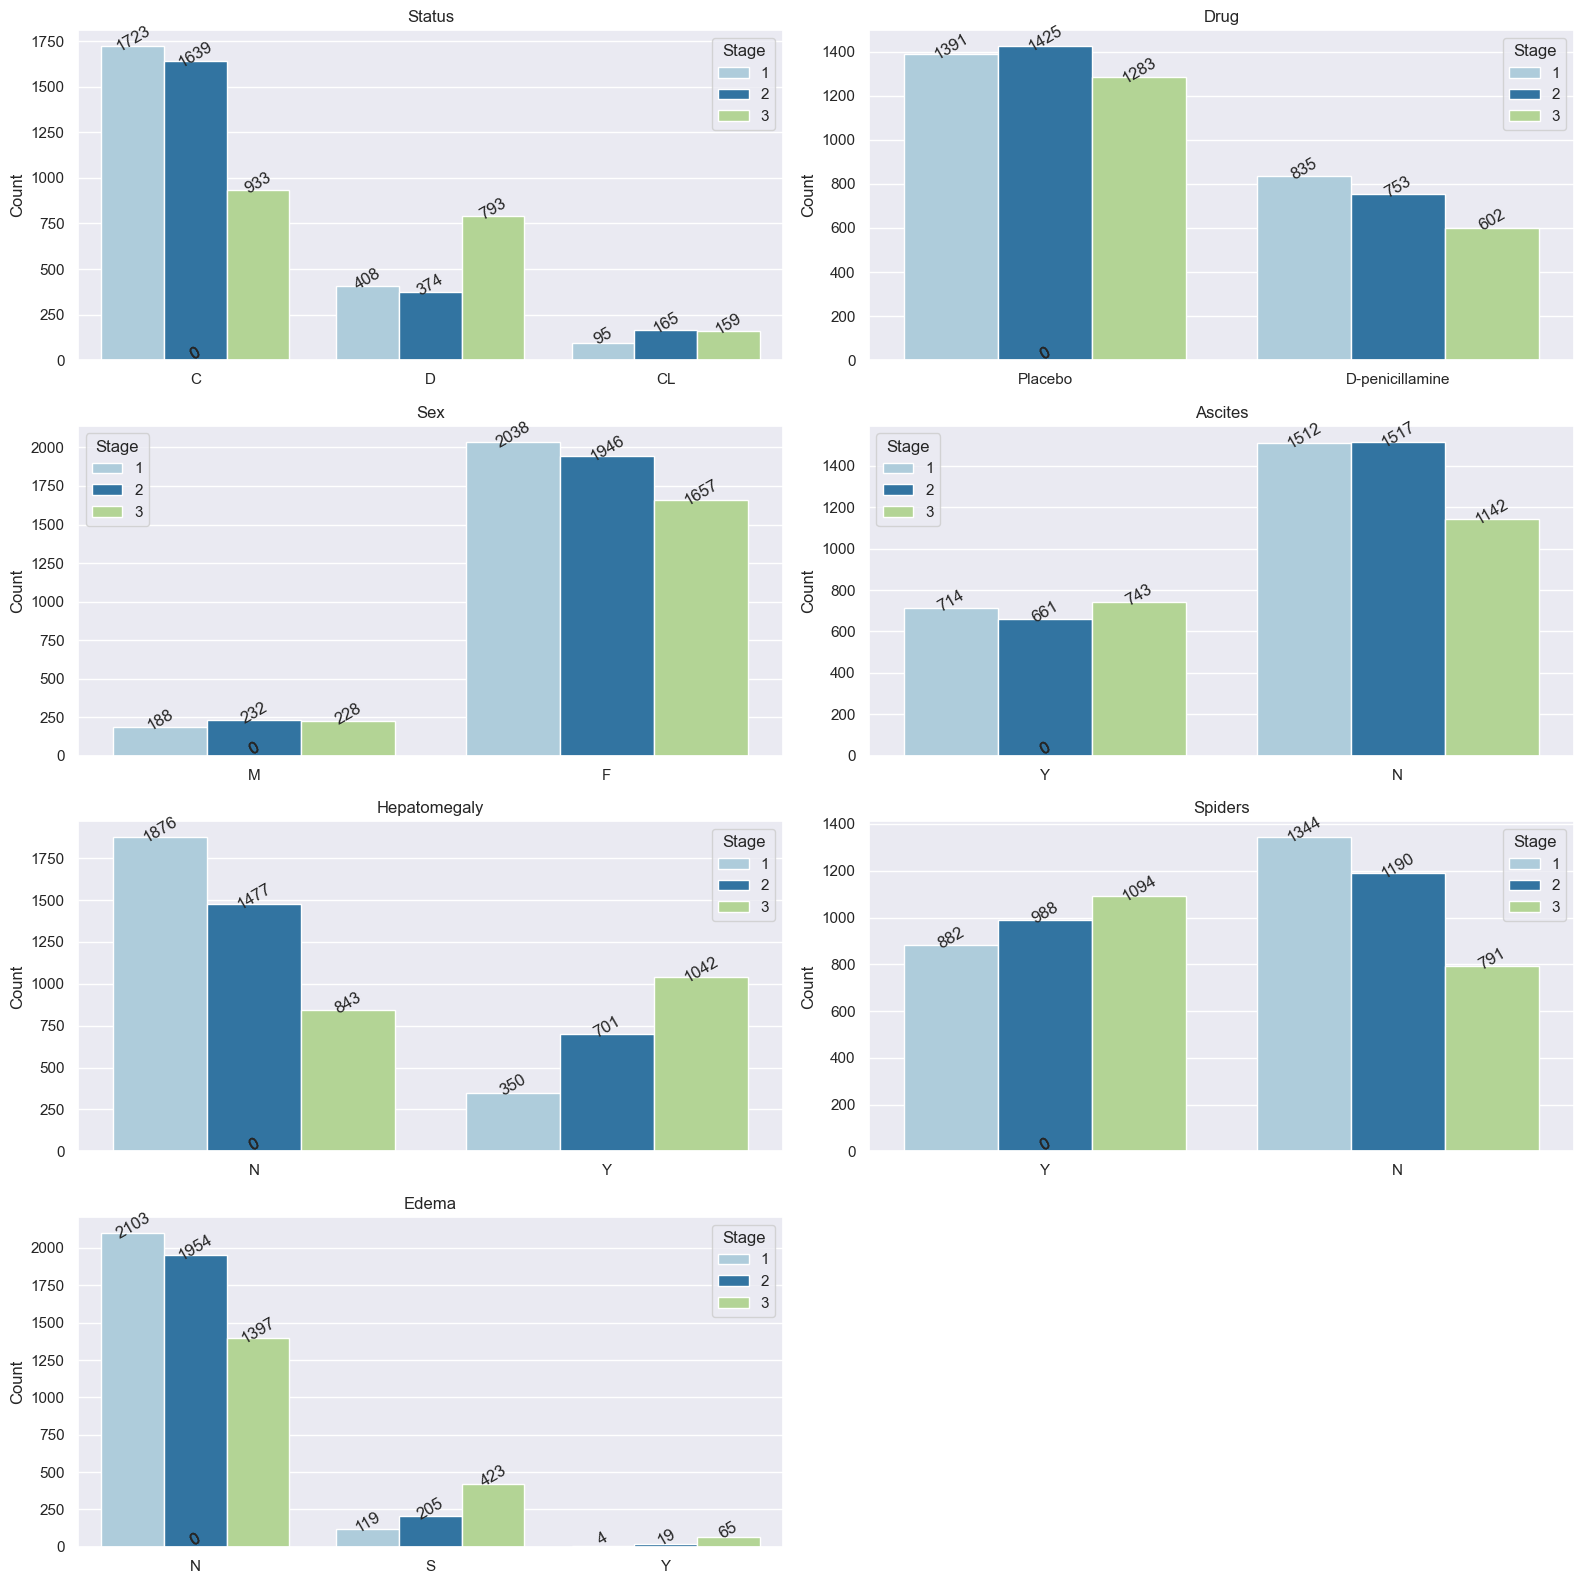

In [37]:
plot_counts(df_no_outliers, cat_features, hue=target)

🔎 **Observations:** We'll remove Edema and Sex features as they might not have so much predictive power.

In [38]:
df_simple = df_no_outliers.drop(['Edema', 'Sex'], axis=1)

In [39]:
cat_features

['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

In [40]:
smp_cat_features = ['Status', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders']

In [54]:
x_train_smp, x_test_smp, y_train_smp, y_test_smp = transform_data(df_simple, target, num_cols, smp_cat_features)

           Acc Mean  Acc STD
Algorithm                   
RFC           0.846    0.018
ABC           0.603    0.026
GBC           0.776    0.018


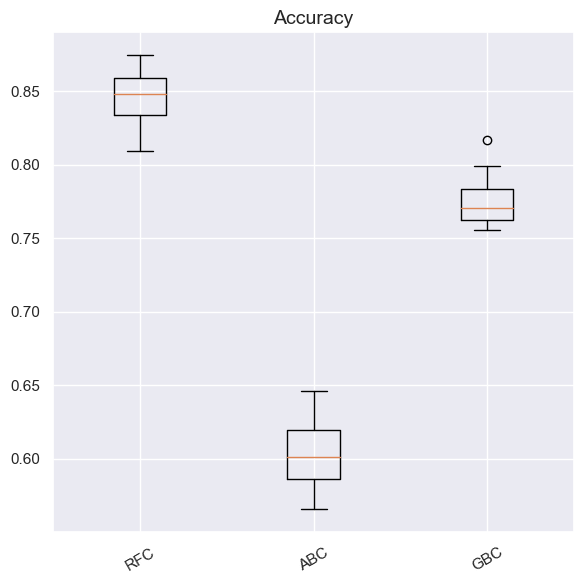

In [42]:
model_evaluation(x_train_smp, y_train_smp, ens_models)

           Acc Mean  Acc STD
Algorithm                   
SVC           0.674    0.019
DTC           0.740    0.022
KNN           0.714    0.023
GNB           0.520    0.013
XGB           0.882    0.013


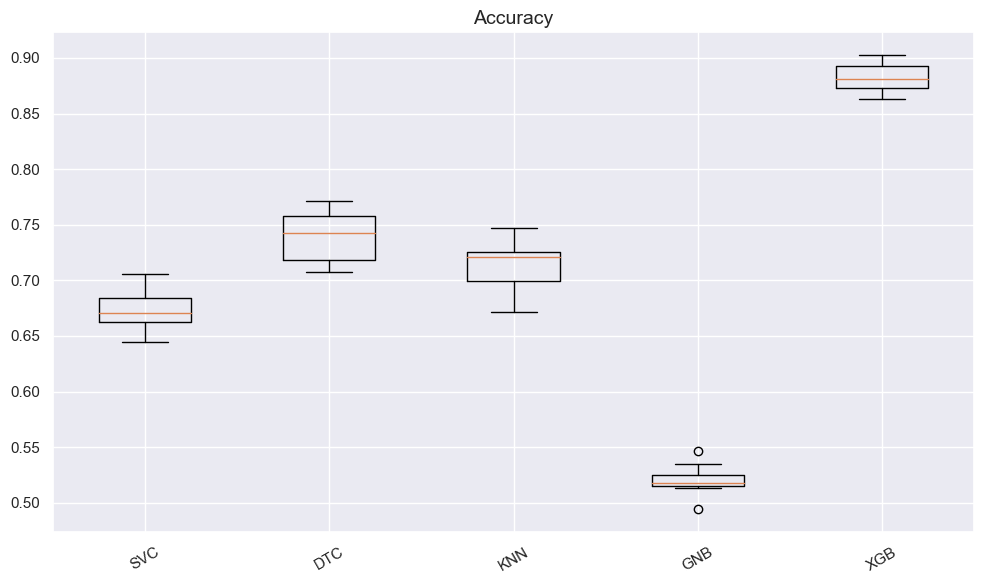

In [43]:
model_evaluation(x_train_smp, y_train_smp, nl_models)

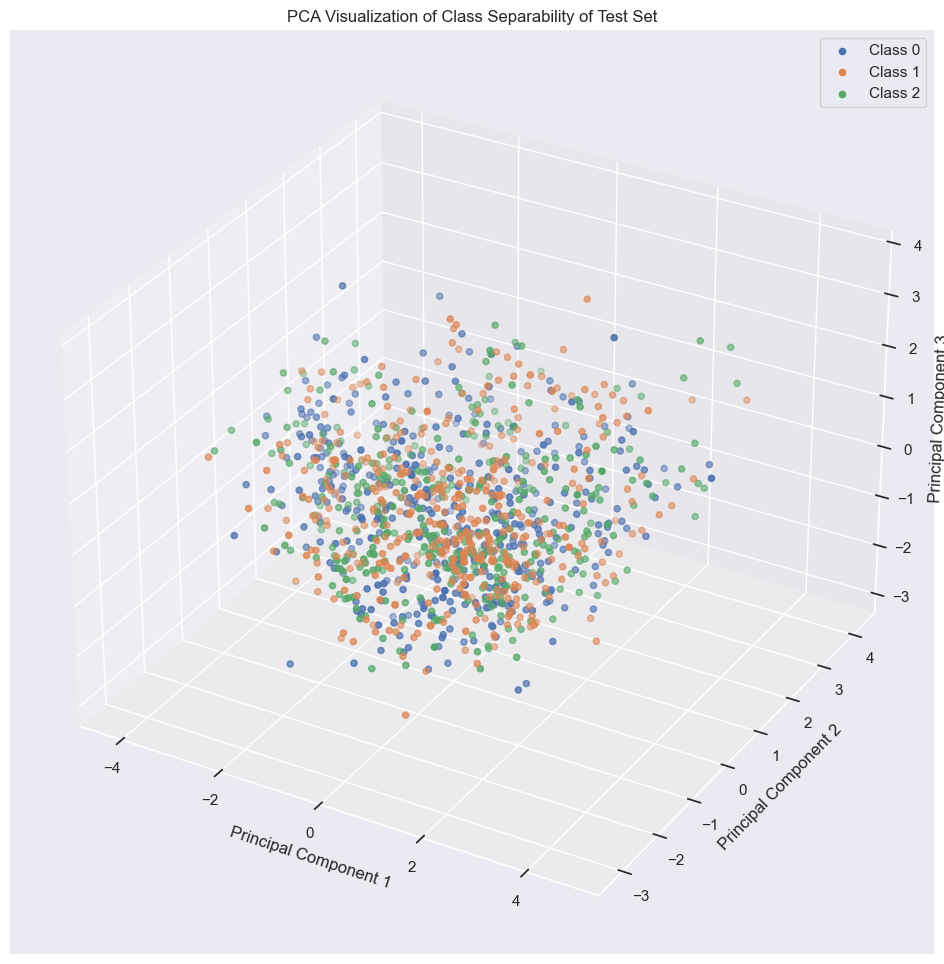

In [44]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_test_smp)

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for target_class in np.unique(y_test):
     ax.scatter(x_pca[y_test == target_class, 0], x_pca[y_test == target_class, 1], x_pca[y_test == target_class, 2], label=f'Class {target_class}')

ax.set_title('PCA Visualization of Class Separability of Test Set')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [45]:
model_def = XGBClassifier()
model_def.fit(x_train_smp, y_train_smp)
y_hat = model_def.predict(x_test_smp)
print(classification_report(y_test_smp, y_hat))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       445
           1       0.86      0.89      0.87       436
           2       0.92      0.91      0.91       377

    accuracy                           0.89      1258
   macro avg       0.89      0.89      0.89      1258
weighted avg       0.89      0.89      0.89      1258



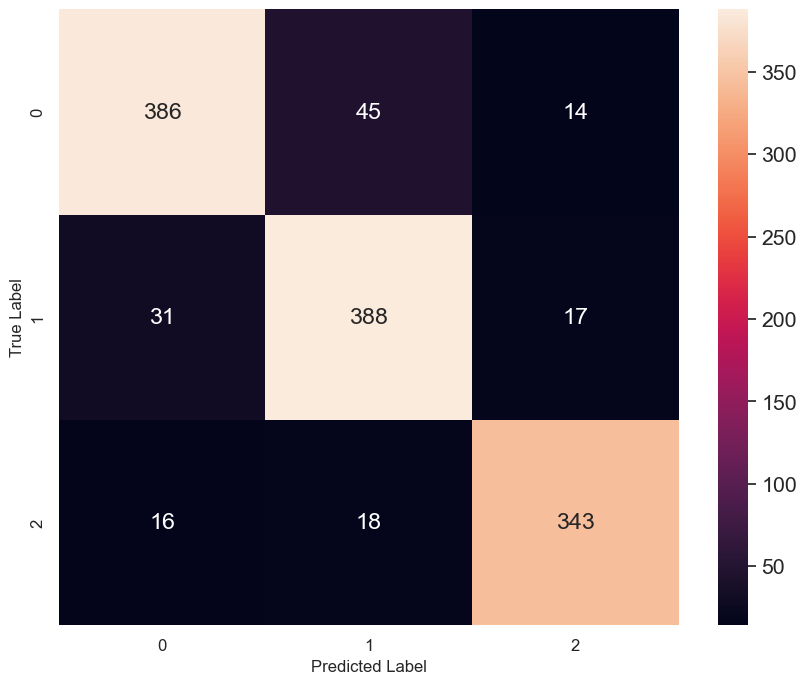

In [46]:
plot_confusion_matrix(y_test_smp, y_hat)

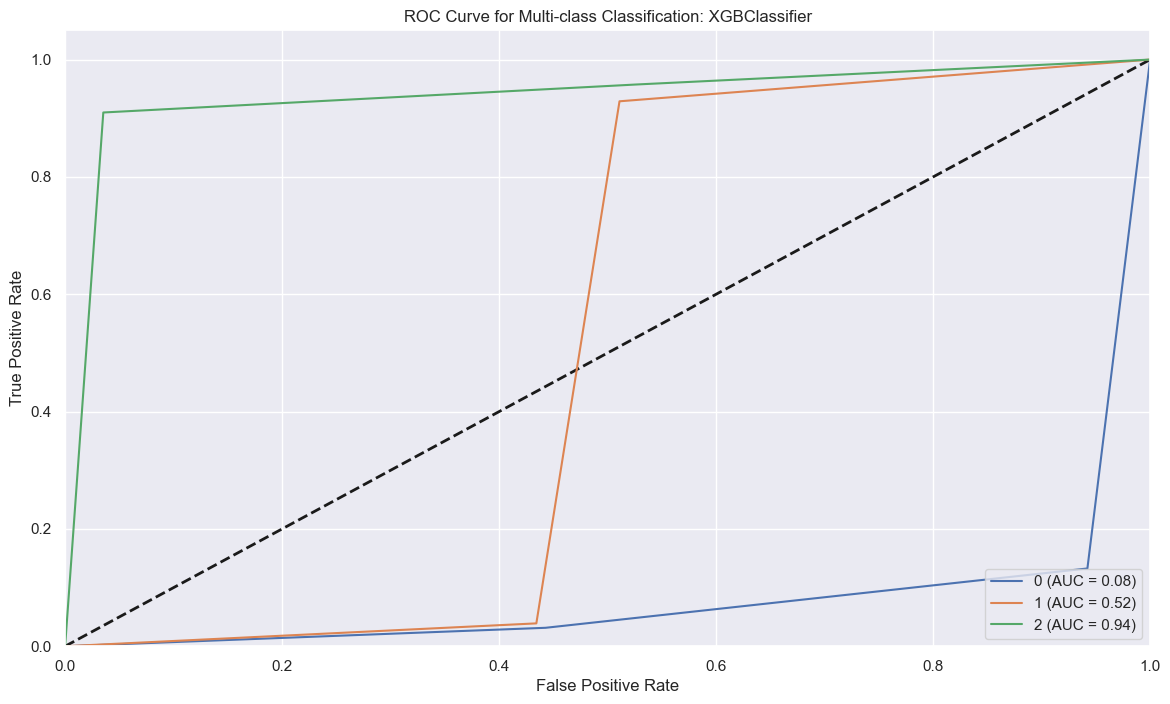

In [47]:
plot_roc_curve(y_test_smp, y_hat, 'XGBClassifier', class_names=[0, 1, 2])

In [48]:
model_rfc = RandomForestClassifier()
model_rfc.fit(x_train_smp, y_train_smp)
y_hat = model_rfc.predict(x_test_smp)
print(classification_report(y_test_smp, y_hat))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       445
           1       0.80      0.85      0.83       436
           2       0.89      0.87      0.88       377

    accuracy                           0.85      1258
   macro avg       0.85      0.85      0.85      1258
weighted avg       0.85      0.85      0.85      1258



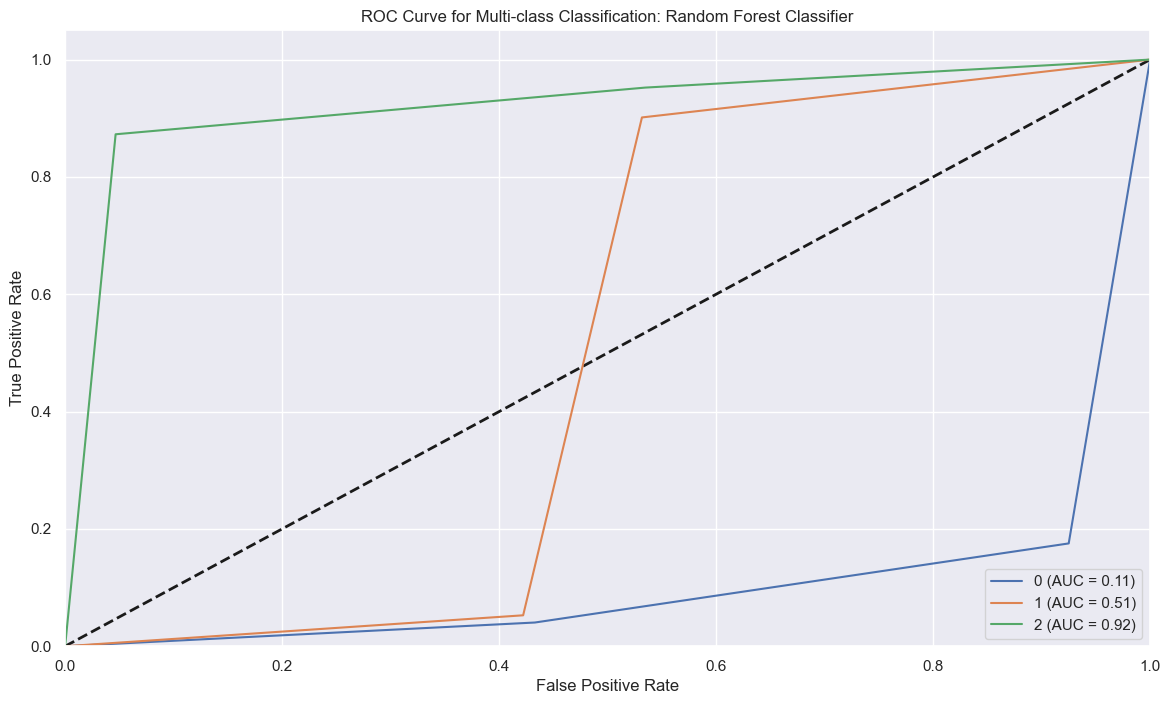

In [49]:
plot_roc_curve(y_test_smp, y_hat, 'Random Forest Classifier', class_names=[0, 1, 2])

🔎 **Observations:** Slightly better not as good as desired.


# 📝 6. Results and Futurework

Developed model can predict if patient might have cirrhosis with high accuracy however, it has high postive rates for some stages. To overcome this issue we may:

1. **Class Separability:** Assess the degree of separability between classes. Even if precision and recall are high, if there is overlap between classes in feature space, it can affect the F1-score differently from AUC. Visualization techniques like PCA or t-SNE can help in understanding the distribution of samples in feature space.
2. **Threshold Selection:** Review the threshold selection for calculating the F1-score. By default, a threshold of 0.5 is commonly used, but it might not be optimal for all classes or scenarios. Consider optimizing thresholds for each class based on domain knowledge or through techniques like ROC analysis.
3. **Model Complexity:** Evaluate the complexity of your model. Sometimes, overly complex models can capture noise in the data, leading to discrepancies between evaluation metrics. Simplifying the model or regularizing it might help improve alignment between F1-score and AUC.

In [55]:
with open('../Models/model.pkl', 'wb') as model_file:
    pickle.dump(model_rfc, model_file)